In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import scipy as sp

## Data import and cleaning

In [2]:
ahi_raw = pd.read_excel('data/Tonsillectomy_Sleep_AHI_07122016.xlsx', 
                        sheetname='AHI', na_values='ND')
ahi_raw.head()

,Citation,REFID,Number of Arms,Rx Grouping,Group_Desc,Intervention_category,Last Assesment tmpt for the study,OUTC_Main_ CATG,Outc_SUB_ CATG,Outcome_specify,...,Outcome Median,Outcome _Q1,Outcome _Q3,Outcome Min,Outcome Max,Outcome 95% L,Outcome 95% H,Other stats Name,Other Stats,Results
0,"Marcus et al., A Randomized Trial of Adenotons...",806_534_359_164_195_120,2,G1:,eAT (early \nadenotonsillectomy),Total tonsillectomy - unspecified,7 mos,Sleep,Sleep-AHI,Apnea hypopnea index (AHI),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Change from BL,IQR: -7.1 to -1.8; diff=-3.5,"AHI: ES=0.57, p<0.001"
1,"Marcus et al., A Randomized Trial of Adenotons...",806_534_359_164_195_120,2,G2:,WWSC (wachful waiting with\n supportive care),Watchful waiting,7 mos,Sleep,Sleep-AHI,Apnea hypopnea index (AHI),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Change from BL,diff=-1.6,NaN
2,"M. Quante, R. Wang, J. Weng, C. L. Rosen, R. A...",806_534_359_164_195_120,2,G1:,eAT (early \nadenotonsillectomy),Total tonsillectomy - unspecified,7 mos,Sleep,Sleep-AHI,Apnea hypopnea index (AHI),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Change score (FUP─BL),─5.3 ± 6.2,"AHI: ES=─0.57, p<0.0001"
3,"M. Quante, R. Wang, J. Weng, C. L. Rosen, R. A...",806_534_359_164_195_120,2,G2:,WWSC (wachful waiting with\n supportive care),Watchful waiting,7 mos,Sleep,Sleep-AHI,Apnea hypopnea index (AHI),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Change score (FUP─BL),─0.7 ± 9.5,NaN
4,"N. Ben-Israel, Y. Zigel, A. Tal, Y. Segev and ...",1729,2,G1:,Adenotonsillectomy with OSA,Total tonsillectomy - unspecified,5.4 mos,Sleep,Sleep-AHI,Apnea hypopnea index (AHI),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P value,p<.02,NaN


In [3]:
keep_columns = ['REFID', 'Intervention_category', 'BASELINE SAMPLE SIZE', 
                'BL Mean', 'BL SD', 'BL_Median', 'BL Min', 'BL Max', 'OUTCOME SAMPLE SIZE', 
                'Outcome\n Mean', 'Outcome \nSD',
                'Outcome \n Median', 'Outcome\n  Min', 'Outcome \n Max']

In [4]:
analysis_subset = ahi_raw.loc[2:, keep_columns]
analysis_subset.columns = ['_'.join([word.strip().lower() for word in k.split('\n')]).replace(' ', '_') 
                             for k in keep_columns]

analysis_subset['treatment'] = analysis_subset.intervention_category.str.startswith('Total').astype(int)

analysis_subset

,refid,intervention_category,baseline_sample_size,bl_mean,bl_sd,bl_median,bl_min,bl_max,outcome_sample_size,outcome_mean,outcome_sd,outcome_median,outcome_min,outcome_max,treatment
2,806_534_359_164_195_120,Total tonsillectomy - unspecified,202,6.9,5.7,NaN,NaN,NaN,202,1.6,3.0,NaN,NaN,NaN,1
3,806_534_359_164_195_120,Watchful waiting,209,6.6,5.6,NaN,NaN,NaN,209,5.9,10.1,NaN,NaN,NaN,0
4,1729,Total tonsillectomy - unspecified,14,10.0,10.3,NaN,NaN,NaN,14,1.1,1.0,NaN,NaN,NaN,1
5,1729,No surgery,6,9.4,7.6,NaN,NaN,NaN,6,13.1,7.7,NaN,NaN,NaN,0
6,915,Total tonsillectomy - unspecified,16,NaN,NaN,14.4,4.1,26.4,16,NaN,NaN,1.1,0.0,19.9,1
7,915,No surgery,16,NaN,NaN,9.3,5.2,31.5,16,NaN,NaN,3.7,0.0,24.6,0


Take median or mean as measure of central tendency

In [5]:
analysis_subset['bl_center'] = analysis_subset.bl_mean.combine_first(analysis_subset.bl_median)

In [6]:
analysis_subset['outcome_center'] = analysis_subset.outcome_mean.combine_first(analysis_subset.outcome_median)

Back-calculate standard deviations from ranges

In [7]:
norm = sp.stats.distributions.norm

find_sd = lambda sd, loc, x: norm.cdf(x, loc=loc, scale=sd) - 0.99

for i in (6,7):
    for j in ('bl', 'outcome'):
        analysis_subset.loc[i, '%s_sd'%j] = sp.optimize.fsolve(find_sd, i, 
                                        args=(analysis_subset.loc[i, '%s_center'%j], 
                                              analysis_subset.loc[i, '%s_max'%j]))

Final clean dataset for analysis

In [8]:
data = analysis_subset.drop(['intervention_category', 'bl_mean', 'bl_median', 'bl_min', 'bl_max',
                     'outcome_mean', 'outcome_median', 'outcome_min', 'outcome_max'], axis=1)

data

,refid,baseline_sample_size,bl_sd,outcome_sample_size,outcome_sd,treatment,bl_center,outcome_center
2,806_534_359_164_195_120,202,5.700000,202,3.000000,1,6.9,1.6
3,806_534_359_164_195_120,209,5.600000,209,10.100000,0,6.6,5.9
4,1729,14,10.300000,14,1.000000,1,10.0,1.1
5,1729,6,7.600000,6,7.700000,0,9.4,13.1
6,915,16,5.158300,16,8.081337,1,14.4,1.1
7,915,16,9.542855,16,8.984039,0,9.3,3.7


## Model specification

Because there are only three studies, I fit a fixed effects model for the treatment effect. The expected arm response was modeled as:

$$\theta_i = \mu + \delta I(t_i)$$

where $I$ is the indicator function, $t_i$ is a dummy variable that equals one for a treatment arm and zero for a control arm. 


The response variable $d_i$ is the difference between the outcome and baseline for arm $i$, and is hypothesized to have the sampling distribution:

$$d_i \sim N(\theta_i, s_i)$$

where $s_i$ is assumed to be the empirical standard error of the difference between the sample means of the outcome and baseline response variables:

$$s_i = \sqrt{\frac{s_i(o)^2}{n_i(o)} + \frac{s_i(b)^2}{n_i(b)}}$$

In [12]:
with pm.Model() as model:
    
    x = data.treatment.values
    d = (data.outcome_center - data.bl_center).values
    se = np.sqrt((data.outcome_sd**2)/data.outcome_sample_size 
                 + (data.bl_sd**2)/data.baseline_sample_size).values
    
    # Effect size
    δ = pm.Normal('δ', 0, sd=20)
    
    # Baseline response
    μ = pm.Normal('μ', 0, sd=20)
    
    θ = μ + δ*x
    
    likelihood = pm.Normal('likelihood', θ, sd=se, observed=d)

In [13]:
with model:
    tr = pm.sample(2000, njobs=2)

Assigned NUTS to δ
Assigned NUTS to μ
 [-----------------100%-----------------] 2000 of 2000 complete in 2.3 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e851630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e0b4160>]], dtype=object)

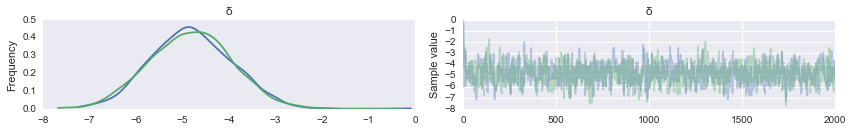

In [14]:
pm.traceplot(tr, varnames=['δ'])

In [15]:
pm.summary(tr, varnames=['δ'])


δ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -4.813           0.890            0.031            [-6.472, -3.056]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.507         -5.427         -4.825         -4.214         -3.070

